# Variational Auto-Encoder w/Categorical Data

As a logical evolution we now try to set-up a variational auto-encoder with embeddings as input.

## Requirements
Before running the experiment, make sure to import the `numpy`, `pandas` and `numba`, `torch`, `tqdm`, `matplotlib`, `scikit-learn`, `captum` packages in your virtual environment
```
> pip install numpy
> pip install pandas
> pip install numba
> pip install torch
> pip install tqdm
> pip install matplotlib
> pip install scikit-learn
> pip install captum
```
And that the notebook can find the `f3atur3s`, `eng1n3` and `m0d3l` packages.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import f3atur3s as ft
import eng1n3.pandas as en
import m0d3l.pytorch as mp
import m0d3l.plot as mplt

import m0d3l.captum as cp

from captum.attr import IntegratedGradients

from typing import Tuple

/home/toms/Jupyter/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set a random seed for Numpy and Torch
Will make sure we always sample in the same way. Makes it easier to compare results. At some point it should been removed to test the model stability.

In [2]:
# Numpy
np.random.seed(42)
# Torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
## Set up the devices, on from the data and one for modeling.
data_device  = torch.device('cpu')
model_device = torch.device('cuda') if torch.cuda.is_available() else data_device

## File Location
Change this to read from another location

In [4]:
file = '../../../../data/bs140513_032310.csv'

## Define Features
All features for this model are set up either as `FeatureBin` or `FeatureIndex` both of which will encode the data as an index/long value. And both of these feature can be used in an embedding layer.

We also define the fraud-label but we will only be using it for the tesing phase. The fraud label is **not used during training**.

In [5]:
age      = ft.FeatureSource('age', ft.FEATURE_TYPE_CATEGORICAL)
gender   = ft.FeatureSource('gender', ft.FEATURE_TYPE_CATEGORICAL)
merchant = ft.FeatureSource('merchant', ft.FEATURE_TYPE_CATEGORICAL)
category = ft.FeatureSource('category', ft.FEATURE_TYPE_CATEGORICAL)
amount   = ft.FeatureSource('amount', ft.FEATURE_TYPE_FLOAT)
fraud    = ft.FeatureSource('fraud', ft.FEATURE_TYPE_INT_8)

amount_binned = ft.FeatureBin('amount_bin', ft.FEATURE_TYPE_INT_16, amount, 30)
age_i        = ft.FeatureIndex('age_index', ft.FEATURE_TYPE_INT_8, age)
gender_i     = ft.FeatureIndex('gender_index', ft.FEATURE_TYPE_INT_8, gender)
merchant_i   = ft.FeatureIndex('merchant_index', ft.FEATURE_TYPE_INT_16, merchant)
category_i   = ft.FeatureIndex('category_index', ft.FEATURE_TYPE_INT_16, category)
fraud_label  = ft.FeatureLabelBinary('fraud_label', ft.FEATURE_TYPE_INT_8, fraud)

# TensorDefinitions
td_i     = ft.TensorDefinition('index', [amount_binned, age_i, gender_i, merchant_i, category_i])
td_label = ft.TensorDefinition('label', [fraud_label])

with en.EnginePandas() as e:
    ti = e.np_from_csv((td_i, td_label), file, inference=False)

print(ti.shapes)
print(ti.dtype_names)

2023-05-14 10:43:06.975 eng1n3.common.engine           INFO     Start Engine...
2023-05-14 10:43:06.975 eng1n3.pandas.pandasengine     INFO     Pandas Version : 1.5.3
2023-05-14 10:43:06.976 eng1n3.pandas.pandasengine     INFO     Numpy Version : 1.23.5
2023-05-14 10:43:06.977 eng1n3.pandas.pandasengine     INFO     Building Panda for : All_r_1 from file ../../../../data/bs140513_032310.csv
2023-05-14 10:43:07.231 eng1n3.pandas.pandasengine     INFO     Reshaping DataFrame to: All_r_1
2023-05-14 10:43:07.234 eng1n3.pandas.pandasengine     INFO     Converting All_r_1 to 2 numpy arrays


((594643, 5), (594643, 1))
('int16', 'int8')


## Create Data-Sets and Loaders
Here we do something slightly differently than in the previous models. We **filter out the fraudulent** transactions for our training and validation test. The training and validation datasets will **only contain non-fraudulent** records. The test dataset will contain **both fraudulent and non-fraudulent** transactions.

In [6]:
train, val, test = ti.split_sequential(30000, 100000)

# Filter. Only keep non-fraud records with label 0. 
train = train.filter_label(0)
val   = val.filter_label(0)

batch_size = 128
# Creating DataSets
train_ds = mp.TensorInstanceNumpyDataSet(train)
val_ds   = mp.TensorInstanceNumpyDataSet(val)
test_ds  = mp.TensorInstanceNumpyDataSet(test)

# Creating an oversampler for the training set.
train_sampler = mp.TensorInstanceNumpyLabelSampler.over_sampler(train)

# Setting up the Dataloaders.
train_dl = train_ds.data_loader(data_device, batch_size, num_workers=2, sampler=train_sampler)
val_dl   = val_ds.data_loader(data_device, batch_size, num_workers=2)
test_dl  = test_ds.data_loader(data_device, batch_size, num_workers=2)

print(train.shapes)
print(val.shapes)
print(test.shapes)

((458847, 5), (458847, 1))
((29670, 5), (29670, 1))
((100000, 5), (100000, 1))


## Create AutoEncoder Model
The next cell creates the auto-encoder model, this is where we specify we would like an variational version of the encoder.

In [7]:
class AutoEncoderModel(mp.VariationalAutoEncoder):
    def __init__(self, model_configuration: mp.ModelConfiguration):
        # Always call init, it is very important to correctly initialize the nn.Module
        super(AutoEncoderModel, self).__init__(model_configuration)
        self.heads   = self.create_heads()
        heads_size   = sum([h.output_size for h in self.heads])
        self.encoder = self.create_linear_encoder(heads_size, layer_sizes=(16, 3), dropout=0.1, bn_interval=0)
        self.decoder = self.create_linear_decoder(layer_sizes=(3, 16), dropout=0.1, bn_interval=0)

    def forward(self, x: Tuple[torch.Tensor, ...]) -> Tuple[torch.Tensor, ...]:
        # Forward through the head, there will only be one head, so no need to concat.
        o = self.heads[0](x[0])
        # The forward creates the latent representation by calling the encoder.
        latent = self.encoder(o)
        # Then feeds the latent representation into the decoder.
        o = self.decoder(latent)
        # Little trick here. We can return 'o' as-is, the VAE decoder returns a Tuple.
        return (o)
        
model = AutoEncoderModel(mp.ModelConfiguration.from_tensor_definitions(ti.target_tensor_def))
model

AutoEncoderModel(
  Number of parameters : 7368. Loss : MultiLabelVAELoss(), mean, 1.0
  (heads): ModuleList(
    (0): TensorDefinitionHead(
      Name=index, lc=Categorical
      (embedding): Embedding(
        (embeddings): ModuleList(
          (0): Embedding(30, 15)
          (1): Embedding(9, 5)
          (2): Embedding(5, 5)
          (3): Embedding(51, 25)
          (4): Embedding(16, 8)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (encoder): LinearVAEEncoder(
    (enc_lin): LinLayer(
      (layers): Sequential(
        (lin_layer_01): Linear(in_features=58, out_features=16, bias=True)
      )
    )
    (mu): Linear(in_features=16, out_features=3, bias=True)
    (sigma): Linear(in_features=16, out_features=3, bias=True)
  )
  (decoder): LinearVAEDecoder(
    (layers): Sequential(
      (linear_decoder): LinLayer(
        (layers): Sequential(
          (lin_layer_01): Linear(in_features=3, out_features=16, bias=True)
          (lin_act_01): ReLU

## Find Learning Rate
For auto-encoders we will use a learning rate that is relatively close to the dropoff point, auto-encoders seem to train better with lower learning rates.

Finding LR in 200 steps: 100%|██████████| 200/200 [00:00<00:00, 250.30it/s]                                                    


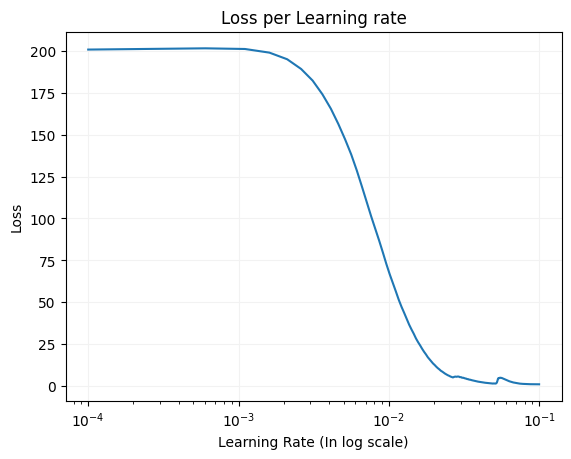

In [8]:
min_lr = 1e-4
max_lr = 1e-1
m_lr = AutoEncoderModel(mp.ModelConfiguration.from_tensor_definitions(ti.target_tensor_def))
o_lr = mp.AdamWOptimizer(m_lr, lr=min_lr)
t_lr = mp.Trainer(m_lr, model_device, train_dl, val_dl)
lrs  = t_lr.find_lr(o_lr, max_lr, 200)
mplt.TrainPlot.plot_lr(lrs);

## Train

In [9]:
EPOCHS = 5

# First create a trainer.
trainer = mp.Trainer(model, model_device, train_dl, val_dl)
# Then an optimizer
optimizer = mp.AdamWOptimizer(model, lr=1e-3)
# Set up a OneCycle Scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer=optimizer.optimizer, 
            max_lr=optimizer.lr,
            steps_per_epoch=trainer.number_of_train_steps,
            epochs=EPOCHS
)

# Run the trainer for [EPOCH] epochs
history = trainer.train(EPOCHS, optimizer, scheduler)

Epoch 005/005: 100%|██████████| 3817/3817 [00:06<00:00, 628.44it/s, t_loss=0.742, v_loss=0.712]                                


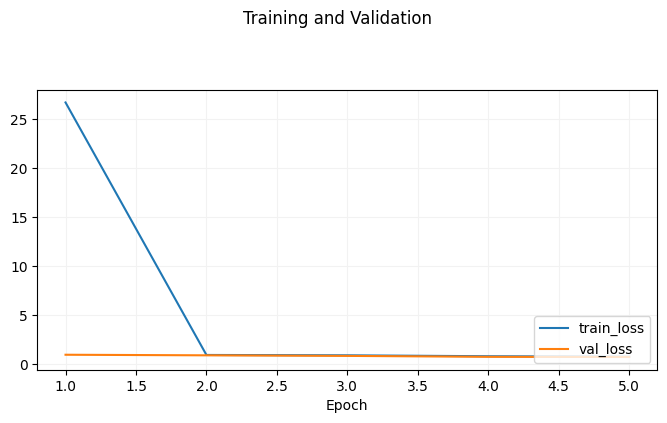

In [10]:
mplt.TrainPlot.plot_history(history, fig_size=(8,8));

## Testing the model

During the testing we see something rather interesting, note how this model has the same AUC score but a very different AP (Average Precision Score) than the regular embedding auto-encoder. The worse AP hints to the fact that his model does not seperate out the fraud from the non-fraud as well as the non-variational embedded version of this model.

Calculating loss in 782 steps: 100%|████████| 782/782 [00:00<00:00, 1258.35it/s]


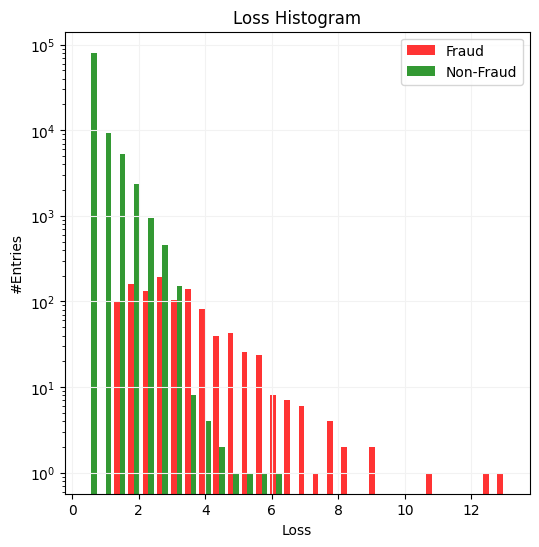

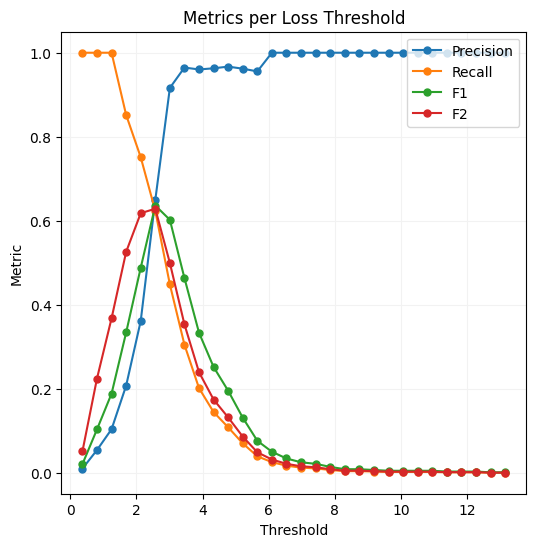

In [11]:
t = mp.Tester(model, model_device, test_dl)
results = t.test_results_loss()
mplt.TestPlot.plot_loss_binary(results, 30, fig_size=(6,6));
mplt.TestPlot.plot_loss_metrics(results, 30, fig_size=(6,6));

------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     98926
         1.0       0.71      0.58      0.64      1074

    accuracy                           0.99    100000
   macro avg       0.85      0.79      0.82    100000
weighted avg       0.99      0.99      0.99    100000


auc score : 0.9891
ap score  : 0.6681
-----------------------------------------------------


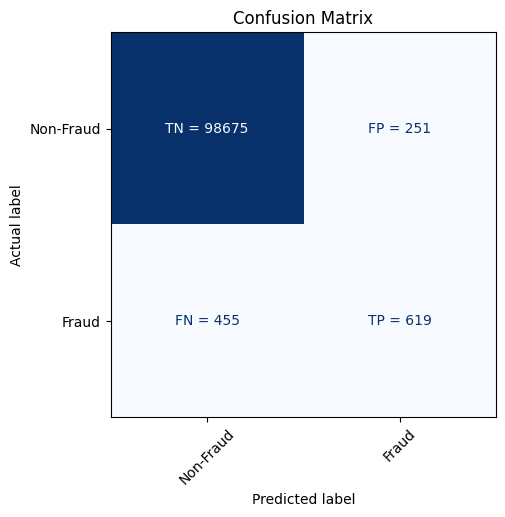

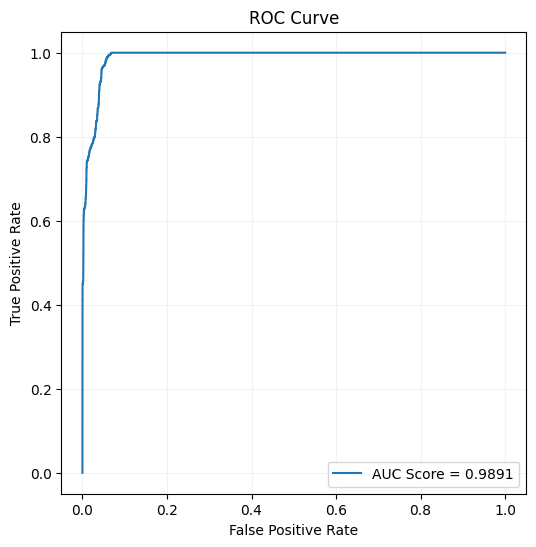

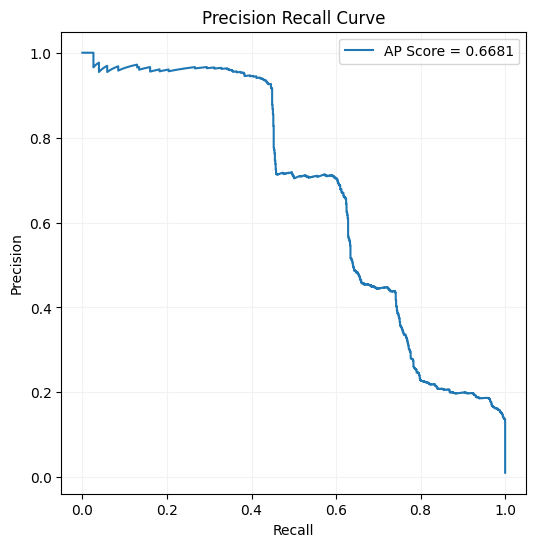

In [17]:
mplt.TestPlot.print_binary_classification_report(results, threshold=2.70)
mplt.TestPlot.plot_binary_confusion_matrix(results, fig_size=(5,5), threshold=2.70);
mplt.TestPlot.plot_roc_curve(results, fig_size=(6,6));
mplt.TestPlot.plot_precision_recall_curve(results, fig_size=(6,6))

## Visualizing the latent space.
We can have some fun trying to visualize what the latent space looks like. In order to do so, we will create a model that uses the `encoder` only, run some test data through and plot the output.

### Create model

In [18]:
class VariationalEncoderOnlyModel(mp.VariationalAutoEncoder):
    def __init__(self, model_configuration: mp.ModelConfiguration):
        # Always call init, it is very important to correctly initialize the nn.Module
        super(VariationalEncoderOnlyModel, self).__init__(model_configuration)
        self.heads   = self.create_heads()
        heads_size   = sum([h.output_size for h in self.heads])
        self.encoder = self.create_linear_encoder(heads_size, layer_sizes=(16, 3), dropout=0.1, bn_interval=0)

    def forward(self, x: Tuple[torch.Tensor, ...]) -> Tuple[torch.Tensor, ...]:
        # Forward through the head, there will only be one head, so no need to concat.
        o = self.heads[0](x[0])
        # The forward creates the latent representation by calling the encoder.
        mu, s = self.encoder(o)
        return (mu,)
    
        
enc_model = VariationalEncoderOnlyModel(mp.ModelConfiguration.from_tensor_definitions(ti.target_tensor_def))
enc_model

VariationalEncoderOnlyModel(
  Number of parameters : 2969. Loss : MultiLabelVAELoss(), mean, 1.0
  (heads): ModuleList(
    (0): TensorDefinitionHead(
      Name=index, lc=Categorical
      (embedding): Embedding(
        (embeddings): ModuleList(
          (0): Embedding(30, 15)
          (1): Embedding(9, 5)
          (2): Embedding(5, 5)
          (3): Embedding(51, 25)
          (4): Embedding(16, 8)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (encoder): LinearVAEEncoder(
    (enc_lin): LinLayer(
      (layers): Sequential(
        (lin_layer_01): Linear(in_features=58, out_features=16, bias=True)
      )
    )
    (mu): Linear(in_features=16, out_features=3, bias=True)
    (sigma): Linear(in_features=16, out_features=3, bias=True)
  )
)

In [19]:
for name, param in model.named_parameters():
    if param.requires_grad:
         print(name)

heads.0.embedding.embeddings.0.weight
heads.0.embedding.embeddings.1.weight
heads.0.embedding.embeddings.2.weight
heads.0.embedding.embeddings.3.weight
heads.0.embedding.embeddings.4.weight
encoder.enc_lin.layers.lin_layer_01.weight
encoder.enc_lin.layers.lin_layer_01.bias
encoder.mu.weight
encoder.mu.bias
encoder.sigma.weight
encoder.sigma.bias
decoder.layers.linear_decoder.layers.lin_layer_01.weight
decoder.layers.linear_decoder.layers.lin_layer_01.bias
decoder.layers.tail.f_weight
decoder.layers.tail.f_bias


In [20]:
with torch.no_grad():
    for se, te in zip(model.heads[0].embedding.embeddings,enc_model.heads[0].embedding.embeddings):
        te.weight.copy_(se.weight)
    enc_model.encoder.enc_lin.layers.lin_layer_01.weight.copy_(model.encoder.enc_lin.layers.lin_layer_01.weight)
    enc_model.encoder.enc_lin.layers.lin_layer_01.bias.copy_(model.encoder.enc_lin.layers.lin_layer_01.bias)
    enc_model.encoder.mu.weight.copy_(model.encoder.mu.weight)
    enc_model.encoder.mu.bias.copy_(model.encoder.mu.bias)
    enc_model.encoder.sigma.weight.copy_(model.encoder.sigma.weight)
    enc_model.encoder.sigma.bias.copy_(model.encoder.sigma.bias)

### Sample and Test data

Now let's do some sampling, this piece of code samples all the fraud from our test data set and a random sample of non-fraud.

In [21]:
N_FRAUD_SAMPLE_SIZE = 5000

# Get the labels
y = torch.squeeze(test_ds[:][1])
# First Separate out the Fraud from the Non-Fraud
fraud=test_ds[np.where(y==1.0)]
n_fraud=test_ds[np.where(y==0.0)]
# Now Sample a number of Non-Fraud records
sample_index = torch.randperm(n_fraud[0].shape[0])[:N_FRAUD_SAMPLE_SIZE]
n_fraud = n_fraud[0][sample_index]

Run both samples through the model and convert to numpy

In [22]:
enc_model.eval()
with torch.no_grad():
    nf = enc_model((n_fraud,))[0].detach().numpy()
    f  = enc_model((fraud))[0].detach().numpy()

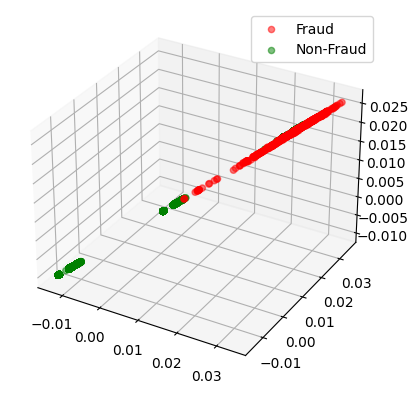

In [23]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for color, label, a in [('red', 'Fraud', f), ('green', 'Non-Fraud', nf)]:
    ax.scatter3D(a[:,0], a[:,1], a[:,2], color=color, label=label, alpha=0.5)
ax.legend()
ax.grid(True)
plt.show();

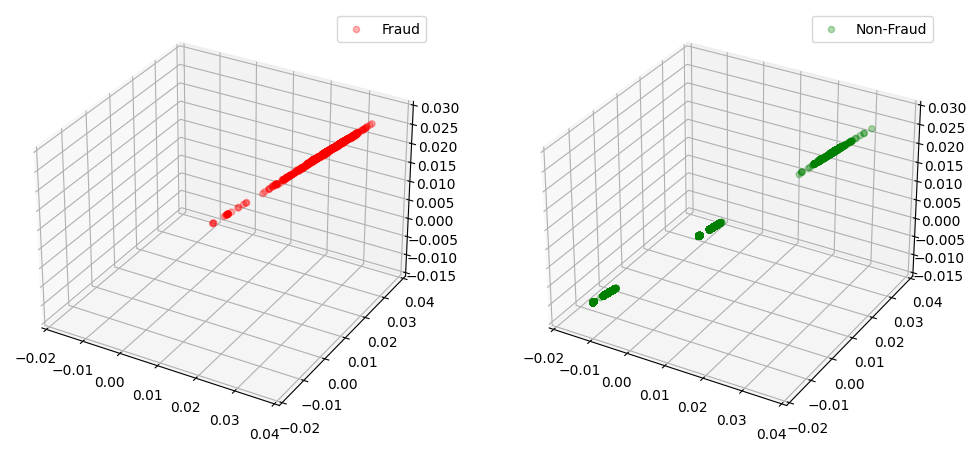

In [24]:
xticks = ax.get_xticks()
yticks = ax.get_yticks()
zticks = ax.get_zticks()
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(1,2,1, projection='3d')
for color, label, a in [('red', 'Fraud', f)]:
    ax1.scatter3D(a[:,0], a[:,1], a[:,2], color=color, label=label, alpha=0.3)
ax1.legend()
ax1.set_xticks(xticks)
ax1.set_yticks(yticks)
ax1.set_zticks(zticks)
ax1.grid(True)
ax2 = fig.add_subplot(1,2,2, projection='3d')
for color, label, a in [('green', 'Non-Fraud', nf)]:
    ax2.scatter3D(a[:,0], a[:,1], a[:,2], color=color, label=label, alpha=0.3)
ax2.legend()
ax2.set_xticks(xticks)
ax2.set_yticks(yticks)
ax2.set_zticks(zticks)
ax2.grid(True)
plt.show();

In [25]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
# PCA the combined non-fraud and fraud.
p = pca.fit_transform(np.concatenate((nf,f)))
pca.explained_variance_ratio_

array([9.9980992e-01, 1.8370124e-04], dtype=float32)

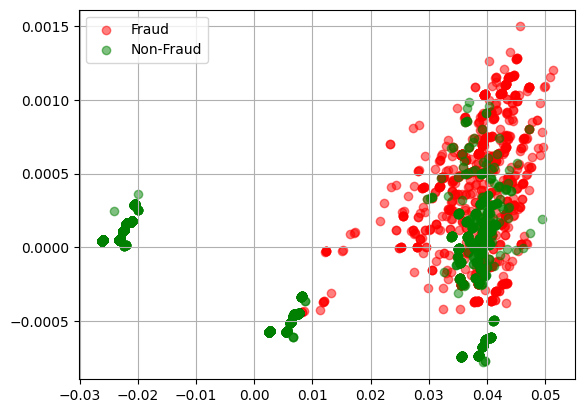

In [26]:
p_nf = p[:N_FRAUD_SAMPLE_SIZE]
p_f  = p[N_FRAUD_SAMPLE_SIZE:]
ax = plt.axes()
for color, label, a in [('red', 'Fraud', p_f), ('green', 'Non-Fraud', p_nf)]:
    ax.scatter(a[:,0], a[:,1], color=color, label=label, alpha=0.5)
plt.legend()
plt.grid(True)
plt.show()

## Conclusion

An interesting experiment, we can see that other than the regular auto-encoders, the embedded variational auto-encoder did not do all that well, we'd have to run more experiments, but this could be because the trained it incorrectly, because the latent space was too contrained (remember the regular embedding auto-encoder used a really big latent space, or this just plain works better on binary input?